In [1]:
import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import isolearn.io as isoio

from scipy.stats import pearsonr

import matplotlib.pyplot as plt


In [2]:
#Load plasmid data
plasmid_dict = isoio.load('../data/random_mpra_legacy/combined_library/processed_data_lifted/apa_plasmid_data_legacy')
plasmid_df = plasmid_dict['plasmid_df']
plasmid_cuts = plasmid_dict['plasmid_cuts']


In [3]:
#Load plasmid test set predictions

model_name = 'aparent_theano_legacy_30_31_34_pasaligned'

test_pred_dict = isoio.load('predictions/apa_plasmid_data_legacy/' + model_name + '_test_predictions')
test_pred_df = test_pred_dict['plasmid_df']
test_cuts_pred = test_pred_dict['cut_prob']


In [26]:
#Join dataframe with prediction table and calculate true cut probabilities

plasmid_df['row_index'] = np.arange(len(plasmid_df), dtype=np.int)
test_pred_df['row_index'] = np.arange(len(test_pred_df), dtype=np.int)

test_df = plasmid_df.join(test_pred_df.set_index('seq'), on='seq', how='inner', lsuffix='_true', rsuffix='_pred')

cut_true = np.array(plasmid_cuts[np.ravel(test_df['row_index_true']), :].todense())

cut_pred = np.array(test_cuts_pred[np.ravel(test_df['row_index_pred']), :].todense())

#Calculate isoform proportions and log odds values

iso_true = np.ravel(test_df['proximal_count'] / test_df['total_count'])
iso_pred = np.ravel(test_df['iso_pred'])
iso_pred_from_cuts = np.sum(cut_pred[:, 60: 60 + 30], axis=-1)

lib = np.array(test_df['library'].values, dtype=np.object)
lib_index = np.array(test_df['library_index'].values, dtype=np.int)


In [21]:
print('Test set n = ' + str(len(test_df)))

Test set n = 99680


In [19]:
def plot_isoform_logodds_scatter(iso_true, iso_pred, lib_index, included_libs, x_label='Predicted Isoform Log Odds', y_label='Observed Isoform Log Odds') :
    #Filter on included libraries
    included_libs = np.array(included_libs)
    
    keep_index = np.array([True if lib_index[i] in included_libs else False for i in range(lib_index.shape[0])], dtype=np.bool)

    #Filter nan-logits
    keep_index = keep_index & ((iso_true > 0.0001) & (iso_true < 0.9999))
    iso_true = iso_true[keep_index]
    iso_pred = iso_pred[keep_index]
    lib_index = lib_index[keep_index]

    logodds_true = np.log(iso_true / (1. - iso_true))
    logodds_pred = np.log(iso_pred / (1. - iso_pred))
    
    #Compute isoform log odds pearson r correlation
    r_val, _ = pearsonr(logodds_pred, logodds_true)

    print('Isoform Log Odds Test Set R^2 = ' + str(round(r_val**2, 2)) + ', n = ' + str(iso_true.shape[0]))

    f = plt.figure(figsize=(5, 5))

    plt.scatter(logodds_pred, logodds_true, s = np.pi * (2 * np.ones(1))**2, alpha=0.15, color='black')
    min_x = max(np.min(logodds_pred), np.min(logodds_true))
    max_x = min(np.max(logodds_pred), np.max(logodds_true))
    min_y = max(np.min(logodds_pred), np.min(logodds_true))
    max_y = min(np.max(logodds_pred), np.max(logodds_true))
    plt.plot([min_x, max_x], [min_y, max_y], alpha=0.5, color='darkblue', linewidth=3)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    
    plt.axis([np.min(logodds_pred), np.max(logodds_pred), np.min(logodds_true), np.max(logodds_true)])
    plt.title('R^2 = ' + str(round(r_val**2, 2)), fontsize=24)
    plt.show()
    plt.close()


Evaluate test set of libraries TOMM5, Alien1, Alien2, ATR, AARS, SOX13
Isoform Log Odds Test Set R^2 = 0.84, n = 66684


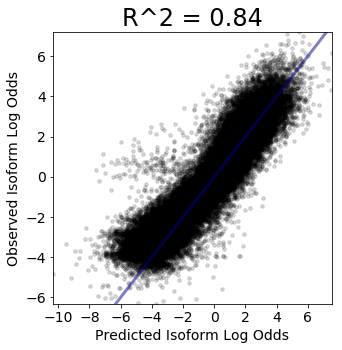

Evaluate test set of libraries HSPE1, SNHG6, WHAMMP2
Isoform Log Odds Test Set R^2 = 0.54, n = 24900


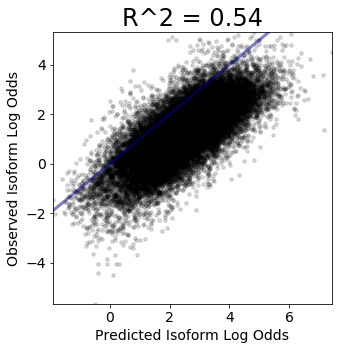

This test shows that cumulative cuts correlate with isoform prediction
Isoform Log Odds Test Set R^2 = 0.94, n = 74699


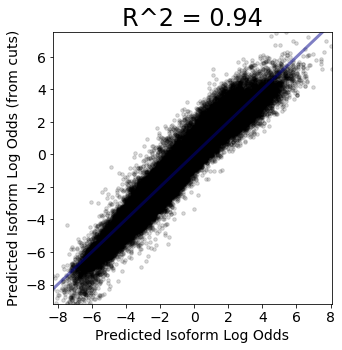

In [20]:
#Evaluate test set isoform prediction performance over all random libraries

print("Evaluate test set of libraries TOMM5, Alien1, Alien2, ATR, AARS, SOX13")

included_libs = [2, 5, 8, 11, 20, 22, 30, 31, 34]
plot_isoform_logodds_scatter(iso_true, iso_pred, lib_index, included_libs)

print("Evaluate test set of libraries HSPE1, SNHG6, WHAMMP2")

included_libs = [32, 33, 35]
plot_isoform_logodds_scatter(iso_true, iso_pred, lib_index, included_libs)

print("This test shows that cumulative cuts correlate with isoform prediction")

included_libs = [2, 5, 8, 11, 20, 22, 30, 31, 34]
plot_isoform_logodds_scatter(iso_pred, iso_pred_from_cuts, lib_index, included_libs, x_label='Predicted Isoform Log Odds', y_label='Predicted Isoform Log Odds (from cuts)')

In [22]:
def plot_inidividual_library_scatters(iso_true, iso_pred, lib_index, included_libs) :
    for i, li in enumerate(included_libs) :

        iso_true_lib = iso_true[lib_index == li]
        iso_pred_lib = iso_pred[lib_index == li]

        f, ax = plt.subplots(1, 2, figsize=(8, 4))

        #Evaluate isoform proportions
        r_val, _ = pearsonr(iso_pred_lib, iso_true_lib)

        print('Library test set = ' + included_lib_names[i])
        print('Isoform Proportion R^2 = ' + str(round(r_val**2, 2)) + ', n = ' + str(iso_true_lib.shape[0]))

        ax[0].scatter(iso_pred_lib, iso_true_lib, s = np.pi * (2 * np.ones(1))**2, alpha=0.15, color='black')
        ax[0].plot([0, 1], [0, 1], alpha=0.5, color='darkblue', linewidth=3)

        plt.sca(ax[0])
        plt.axis([0, 1, 0, 1])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Pred Proportion", fontsize=14)
        plt.ylabel("True Proportion", fontsize=14)
        plt.title(included_lib_names[i] + ' (R^2 = ' + str(round(r_val**2, 2)) + ')', fontsize=14)

        #Evaluate isoform log odds
        keep_index = (iso_true_lib > 0.0001) & (iso_true_lib < 0.9999)
        iso_true_lib = iso_true_lib[keep_index]
        iso_pred_lib = iso_pred_lib[keep_index]

        logodds_pred_lib = np.ravel(np.log(iso_pred_lib / (1. - iso_pred_lib)))
        logodds_true_lib = np.ravel(np.log(iso_true_lib / (1. - iso_true_lib)))

        r_val, _ = pearsonr(logodds_pred_lib, logodds_true_lib)

        print('Isoform Log Odds R^2 = ' + str(round(r_val**2, 2)) + ', n = ' + str(iso_true_lib.shape[0]))

        ax[1].scatter(logodds_pred_lib, logodds_true_lib, s = np.pi * (2 * np.ones(1))**2, alpha=0.15, color='black')
        min_x = max(np.min(logodds_pred_lib), np.min(logodds_true_lib))
        max_x = min(np.max(logodds_pred_lib), np.max(logodds_true_lib))
        min_y = max(np.min(logodds_pred_lib), np.min(logodds_true_lib))
        max_y = min(np.max(logodds_pred_lib), np.max(logodds_true_lib))
        ax[1].plot([min_x, max_x], [min_y, max_y], alpha=0.5, color='darkblue', linewidth=3)

        plt.sca(ax[1])
        plt.axis([np.min(logodds_pred_lib), np.max(logodds_pred_lib), np.min(logodds_true_lib), np.max(logodds_true_lib)])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Pred Log Odds", fontsize=14)
        plt.ylabel("True Log Odds", fontsize=14)
        plt.title(included_lib_names[i] + ' (R^2 = ' + str(round(r_val**2, 2)) + ')', fontsize=14)

        plt.tight_layout()
        plt.show()
        plt.close()


Evaluate test set of individual libraries
Library test set = TOMM5 1
Isoform Proportion R^2 = 0.55, n = 8307
Isoform Log Odds R^2 = 0.52, n = 8306


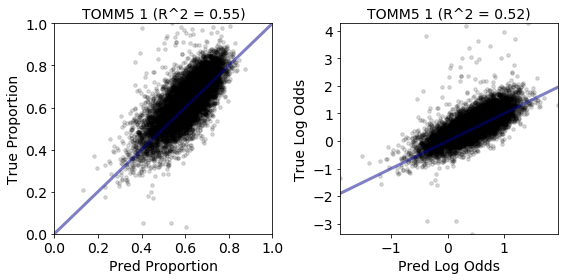

Library test set = TOMM5 2
Isoform Proportion R^2 = 0.55, n = 8307
Isoform Log Odds R^2 = 0.52, n = 8289


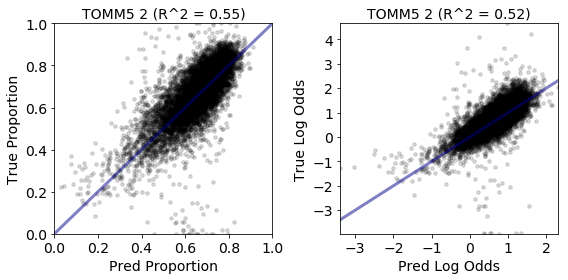

Library test set = TOMM5 3
Isoform Proportion R^2 = 0.79, n = 8307
Isoform Log Odds R^2 = 0.66, n = 5067


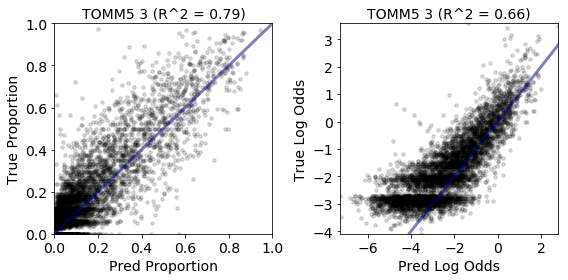

Library test set = TOMM5 4
Isoform Proportion R^2 = 0.77, n = 8306
Isoform Log Odds R^2 = 0.7, n = 6883


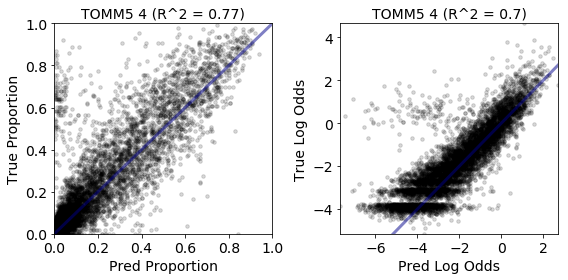

Library test set = Alien2
Isoform Proportion R^2 = 0.73, n = 8306
Isoform Log Odds R^2 = 0.54, n = 7068


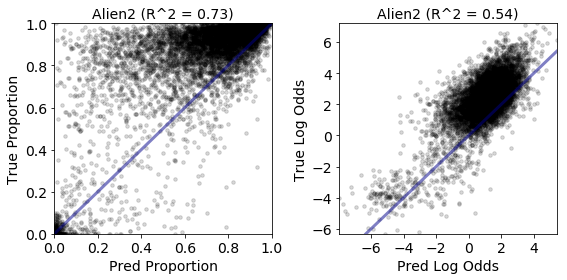

Library test set = Alien1
Isoform Proportion R^2 = 0.85, n = 8306
Isoform Log Odds R^2 = 0.81, n = 8259


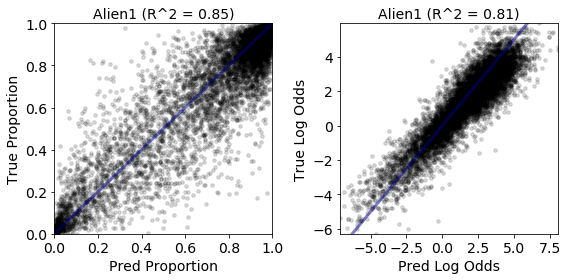

Library test set = ATR
Isoform Proportion R^2 = 0.5, n = 8306
Isoform Log Odds R^2 = 0.48, n = 8162


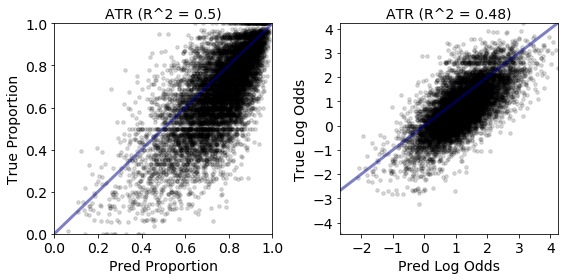

Library test set = AARS
Isoform Proportion R^2 = 0.72, n = 8307
Isoform Log Odds R^2 = 0.7, n = 8176


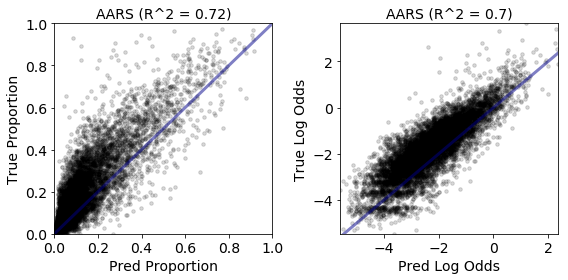

Library test set = HSPE1
Isoform Proportion R^2 = 0.59, n = 8307
Isoform Log Odds R^2 = 0.61, n = 8293


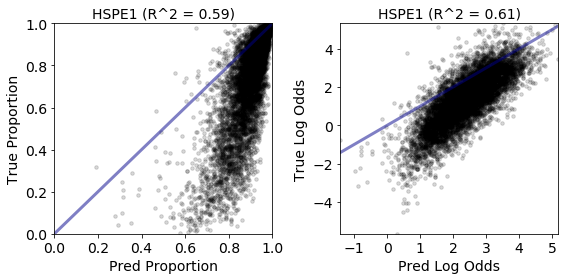

Library test set = SNHG6
Isoform Proportion R^2 = 0.37, n = 8307
Isoform Log Odds R^2 = 0.41, n = 8307


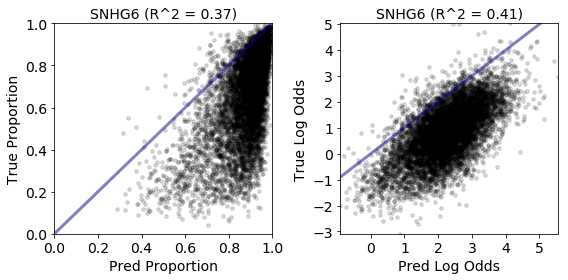

Library test set = SOX13
Isoform Proportion R^2 = 0.76, n = 8307
Isoform Log Odds R^2 = 0.66, n = 6474


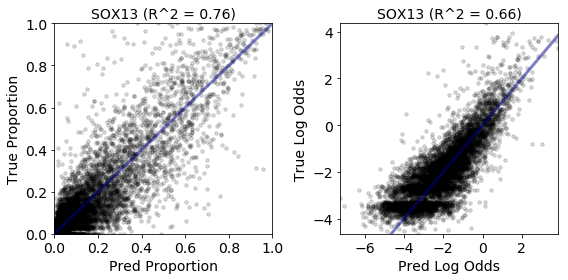

Library test set = WHAMMP2
Isoform Proportion R^2 = 0.37, n = 8307
Isoform Log Odds R^2 = 0.33, n = 8300


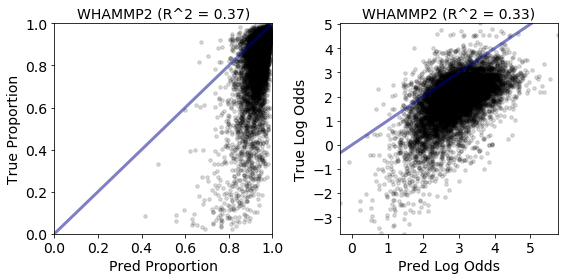

In [23]:
#Evaluate test set isoform prediction performance on individual random libraries

print("Evaluate test set of individual libraries")

included_libs = [2, 5, 8, 11, 20, 22, 30, 31, 32, 33, 34, 35]
included_lib_names = ['TOMM5 1', 'TOMM5 2', 'TOMM5 3', 'TOMM5 4', 'Alien2', 'Alien1', 'ATR', 'AARS', 'HSPE1', 'SNHG6', 'SOX13', 'WHAMMP2']

plot_inidividual_library_scatters(iso_true, iso_pred_from_cuts, lib_index, included_libs)


In [27]:
def plot_cut_position_scatters(cut_true, cut_pred, lib_index, included_libs) :
    #Filter on included libraries
    included_libs = np.array(included_libs)
    
    keep_index = np.array([True if lib_index[i] in included_libs else False for i in range(lib_index.shape[0])], dtype=np.bool)

    cut_start = 57
    cut_end = 107
    
    #Filter nan-logits
    keep_index = keep_index & (np.sum(cut_true[:, cut_start:cut_end], axis=-1) > 0.5)
    cut_true = cut_true[keep_index, :]
    cut_pred = cut_pred[keep_index, :]
    lib_index = lib_index[keep_index]
    
    cut_true = cut_true[:, cut_start:cut_end] / np.sum(cut_true[:, cut_start:cut_end], axis=-1).reshape(-1, 1)
    cut_pred = cut_pred[:, cut_start:cut_end] / np.sum(cut_pred[:, cut_start:cut_end], axis=-1).reshape(-1, 1)
    
    mean_cut_true = np.sum(np.arange(cut_end - cut_start).reshape(1, -1) * cut_true, axis=-1)
    mean_cut_pred = np.sum(np.arange(cut_end - cut_start).reshape(1, -1) * cut_pred, axis=-1)
    
    #Compute isoform log odds pearson r correlation
    r_val, _ = pearsonr(mean_cut_pred, mean_cut_true)

    print('Mean Cut Position Test Set R^2 = ' + str(round(r_val**2, 2)) + ', n = ' + str(cut_true.shape[0]))

    f, ax = plt.subplots(1, 2, figsize=(8, 4))

    ax[0].scatter(mean_cut_pred, mean_cut_true, s = np.pi * (2 * np.ones(1))**2, alpha=0.15, color='darkblue')

    plt.sca(ax[0])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel("Pred Mean Cut Position", fontsize=14)
    plt.ylabel("True Mean Cut Position", fontsize=14)
    
    plt.title('R^2 = ' + str(round(r_val**2, 2)), fontsize=24)
    
    sort_index = np.argsort(mean_cut_true)
    mean_cut_true = mean_cut_true[sort_index]
    mean_cut_pred = mean_cut_pred[sort_index]

    ax[1].scatter(mean_cut_pred, np.arange(mean_cut_true.shape[0]), s = np.pi * (2 * np.ones(1))**2, alpha=0.15, color='darkblue')
    ax[1].plot(mean_cut_true, np.arange(mean_cut_true.shape[0]), color='darkred', linewidth=3, linestyle='--')
    
    plt.sca(ax[1])
    plt.xticks(fontsize=14)
    plt.yticks([], fontsize=14)

    plt.xlabel("Pred Mean Cut Position", fontsize=14)
    plt.ylabel("Sequences", fontsize=14)
    
    plt.title('R^2 = ' + str(round(r_val**2, 2)), fontsize=24)
    
    plt.tight_layout()
    plt.show()
    plt.close()



Evaluate test set cut site prediction on Alien1 library
Mean Cut Position Test Set R^2 = 0.81, n = 6563


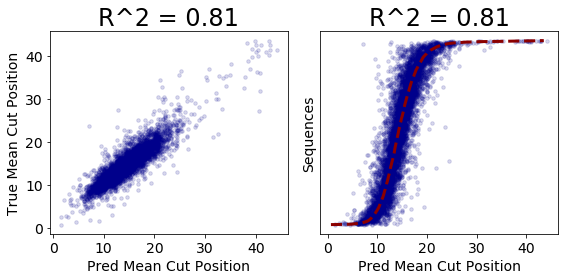

Evaluate test set cut site prediction on HSPE1 library
Mean Cut Position Test Set R^2 = 0.58, n = 7861


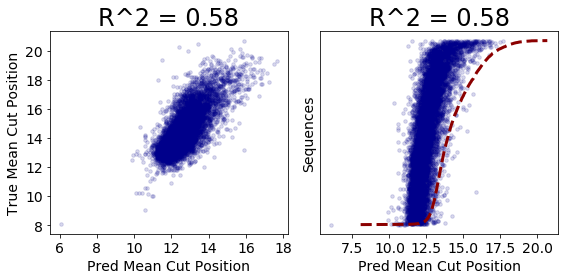

In [28]:
#Evaluate predicted vs. observed mean cut position on test sets

print("Evaluate test set cut site prediction on Alien1 library")

plot_cut_position_scatters(cut_true, cut_pred, lib_index, [22])

print("Evaluate test set cut site prediction on HSPE1 library")

plot_cut_position_scatters(cut_true, cut_pred, lib_index, [35])

In [5]:
#Load non-collapsed array data
array_dict = pickle.load(open('apa_array_data_seq.pickle', 'rb'))
array_df = array_dict['array_df']
array_cuts = array_dict['pooled_cuts']

array_index = np.arange(len(array_df), dtype=np.int)

print('Array set size = ' + str(array_index.shape[0]))

Array set size = 186066


In [14]:
#Load master_seq variant data
delta_dict = pickle.load(open('apa_variant_data_master_seq.pickle', 'rb'))
delta_df = delta_dict['variant_df']
delta_var_cuts = delta_dict['pooled_cuts_var']
delta_ref_cuts = delta_dict['pooled_cuts_ref']

delta_index = np.arange(len(delta_df), dtype=np.int)

print('Variant set size = ' + str(delta_index.shape[0]))

Variant set size = 21734


In [7]:
#Load master_seq_ver variant data
delta_dict = pickle.load(open('apa_variant_data_master_seq_ver.pickle', 'rb'))
delta_df = delta_dict['variant_df']
delta_var_cuts = delta_dict['pooled_cuts_var']
delta_ref_cuts = delta_dict['pooled_cuts_ref']

keep_index = np.nonzero(delta_df["array_version_var"] == 'hifi')[0]
delta_df = delta_df.iloc[keep_index].copy().reset_index(drop=True)
delta_var_cuts = delta_var_cuts[keep_index, :]
delta_ref_cuts = delta_ref_cuts[keep_index, :]

delta_index = np.arange(len(delta_df), dtype=np.int)

print('Variant set size = ' + str(delta_index.shape[0]))

Variant set size = 21601


In [15]:
#Load held-out gene id list
temp_dict = pickle.load(open('apa_array_data_part_2_master_seq.pickle', 'rb'))

held_out_genes = list(temp_dict['array_df']['gene'].unique())

print("Held-out genes = " + str(len(held_out_genes)))


Held-out genes = 592


In [43]:
prox_range = (np.arange(30, dtype=np.int) + 77).tolist()
norm_range = np.arange(206).tolist()

unique_libraries = np.array(['tomm5_up_n20c20_dn_c20', 'tomm5_up_c20n20_dn_c20', 'tomm5_up_n20c20_dn_n20', 'tomm5_up_c20n20_dn_n20', 'doubledope', 'simple', 'atr', 'hsp', 'snh', 'sox', 'wha', 'array', 'aar'], dtype=np.object)

array_gen = iso.DataGenerator(
    array_index,
    {'df' : array_df, 'cuts' : array_cuts},
    batch_size=1,
    inputs = [
        {
            'id' : 'seq',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : iso.SequenceExtractor('seq_ext', start_pos=180, end_pos=180 + 205),
            'encoder' : iso.OneHotEncoder(seq_length=205),
            'dim' : (205, 4, 1),
            'sparsify' : False
        },
        {
            'id' : 'lib',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: 'array',
            'encoder' : iso.CategoricalEncoder(n_categories=len(unique_libraries), categories=unique_libraries),
            'sparsify' : False
        },
        {
            'id' : 'distal_pas',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: 1,
            'encoder' : None,
            'sparsify' : False
        }
    ],
    outputs = [
        {
            'id' : 'prox_usage',
            'source_type' : 'matrix',
            'source' : 'cuts',
            'extractor' : iso.CountExtractor(start_pos=180, end_pos=180 + 205, static_poses=[-1], sparse_source=True),
            'transformer' : iso.ProportionTransformer(prox_range, norm_range, laplace_smoothing=0.0),
            'sparsify' : False
        }
    ],
    randomizers = [],
    shuffle = False
)


In [44]:
#Predict from array generator
iso_pred_dedicated, cut_pred = model.predict_generator(array_gen, workers=4, use_multiprocessing=True)

iso_pred_dedicated = np.ravel(iso_pred_dedicated)
iso_pred = np.ravel(np.sum(cut_pred[:, 77: 77 + 30], axis=1))

pseudo_count = 1.0
cut_true = np.concatenate([np.array(array_cuts[:, 180: 180 + 205].todense()), np.array(array_cuts[:, -1].todense()).reshape(-1, 1)], axis=-1)
iso_true = (np.sum(cut_true[:, 77: 77 + 30], axis=1) + pseudo_count) / (np.sum(cut_true[:, :], axis=1) + 2. * pseudo_count)

array_df['iso_pred_dedicated'] = iso_pred_dedicated
array_df['iso_pred'] = iso_pred
array_df['iso_true'] = iso_true


In [45]:
array_df['iso_pred_mix'] = array_df['iso_pred']
#array_df['iso_pred_mix'] = (array_df['iso_pred'] + array_df['iso_pred_dedicated']) / 2.

array_df_group = array_df.groupby("master_seq")
array_df_agg = array_df_group.agg({
    #'iso_pred' : lambda x: tuple(x),
    'iso_pred_mix' : lambda x: tuple(x),
    'iso_true' : lambda x: tuple(x),
    'pooled_total_count' : lambda x: tuple(x)
})

array_df_agg['sum_total_count'] = array_df_agg['pooled_total_count'].apply(lambda x: np.sum(list(x)))

array_df_agg['weighted_iso_true'] = array_df_agg.apply(
    lambda row: np.sum(np.ravel(list(row['iso_true'])) * np.ravel(list(row['pooled_total_count']))) / row['sum_total_count']
    ,axis=1
)

array_df_agg['weighted_iso_pred'] = array_df_agg.apply(
    lambda row: np.sum(np.ravel(list(row['iso_pred_mix'])) * np.ravel(list(row['pooled_total_count']))) / row['sum_total_count']
    ,axis=1
)

array_df_agg['weighted_logodds_true'] = np.log(array_df_agg['weighted_iso_true'] / (1. - array_df_agg['weighted_iso_true']))
array_df_agg['weighted_logodds_pred'] = np.log(array_df_agg['weighted_iso_pred'] / (1. - array_df_agg['weighted_iso_pred']))

array_df_agg = array_df_agg[['weighted_iso_true', 'weighted_logodds_true', 'weighted_iso_pred', 'weighted_logodds_pred']]


In [46]:
delta_df_pred = delta_df.set_index('master_seq').join(array_df_agg, how='inner').copy().reset_index()
delta_df_pred = delta_df_pred.join(array_df_agg, on='wt_seq', how='inner', rsuffix='_ref')

delta_df_pred['weighted_delta_logodds_true'] = delta_df_pred['weighted_logodds_true'] - delta_df_pred['weighted_logodds_true_ref']
delta_df_pred['weighted_delta_logodds_pred'] = delta_df_pred['weighted_logodds_pred'] - delta_df_pred['weighted_logodds_pred_ref']


In [47]:
delta_df_filtered = delta_df_pred.query("n_barcodes_var >= 5 and n_barcodes_ref >= 5 and mean_total_count_var >= 200 and mean_total_count_ref >= 200")

#Filter all dataframes on included experiments (snvs)
included_experiments = ['acmg_apadb', 'acmg_polyadb', 'sensitive_genes', 'clinvar_wt', 'human_variant']

filter_query = ""

for exp_index, included_experiment in enumerate(included_experiments) :
    filter_query += "experiment == '" + str(included_experiment) + "'"
    if exp_index < len(included_experiments) - 1 :
        filter_query += " or "


variant_df = delta_df.query(filter_query)
print(len(variant_df))

variant_df_filtered = delta_df_filtered.query(filter_query)
print(len(variant_df_filtered))

13794
12350


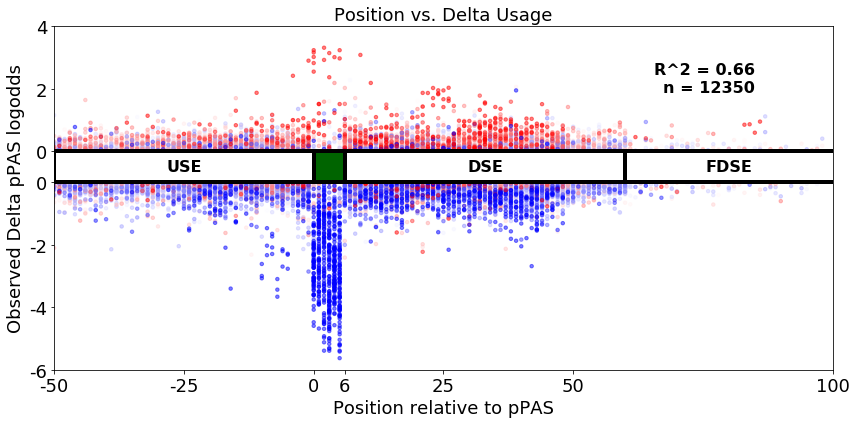

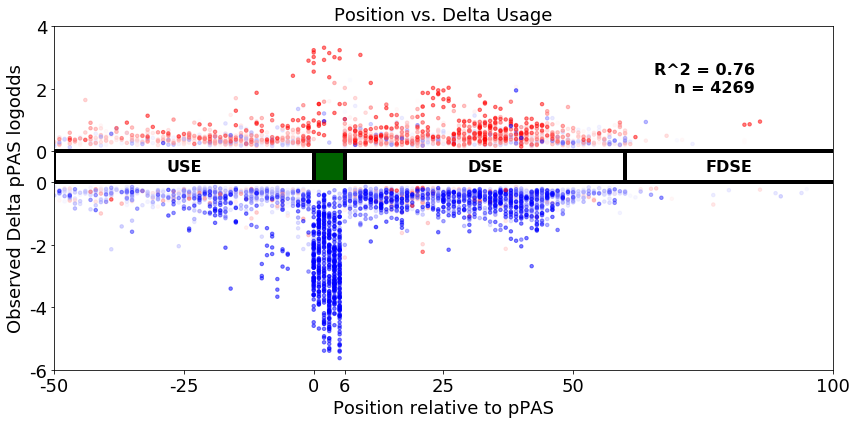

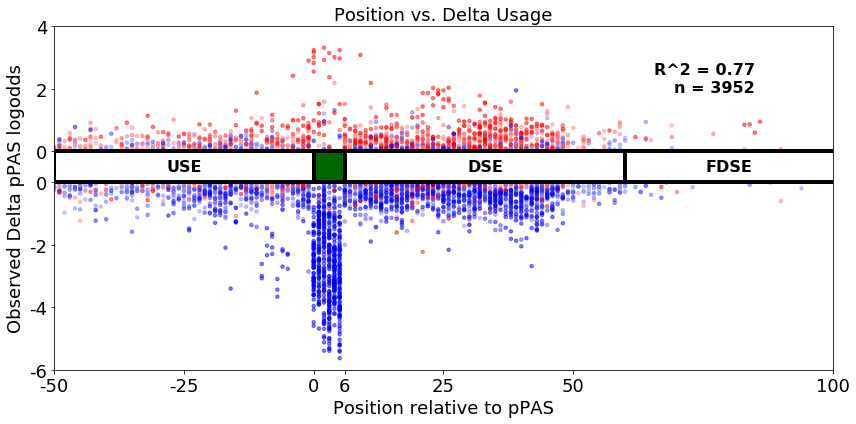

In [48]:
save_figs = False

#All variants
df_to_use = variant_df_filtered

figsize=(12, 6)

fig_name = None
if save_figs :
    fig_name = 'position_delta_all'
plot_position_delta_scatter(df_to_use, min_pred_filter=0.0, pred_column='weighted_delta_logodds_pred', figsize=figsize, fig_name=fig_name, vmin=-0.5, vmax=0.5, fig_dpi=150, annotate=None)

#Significant variants
df_to_use = variant_df_filtered.query("delta_p_val < 0.0001")

figsize=(12, 6)

fig_name = None
if save_figs :
    fig_name = 'position_delta_all'
plot_position_delta_scatter(df_to_use, min_pred_filter=0.0, pred_column='weighted_delta_logodds_pred', figsize=figsize, fig_name=fig_name, vmin=-0.5, vmax=0.5, fig_dpi=150, annotate=None)


#Filtered on prediction >= (log)
df_to_use = variant_df_filtered

fig_name = None
if save_figs :
    fig_name = 'position_delta_all_pred_ge_02'
plot_position_delta_scatter(df_to_use, min_pred_filter=0.2, pred_column='weighted_delta_logodds_pred', figsize=figsize, fig_name=fig_name, vmin=-0.5, vmax=0.5, fig_dpi=150, annotate=None)


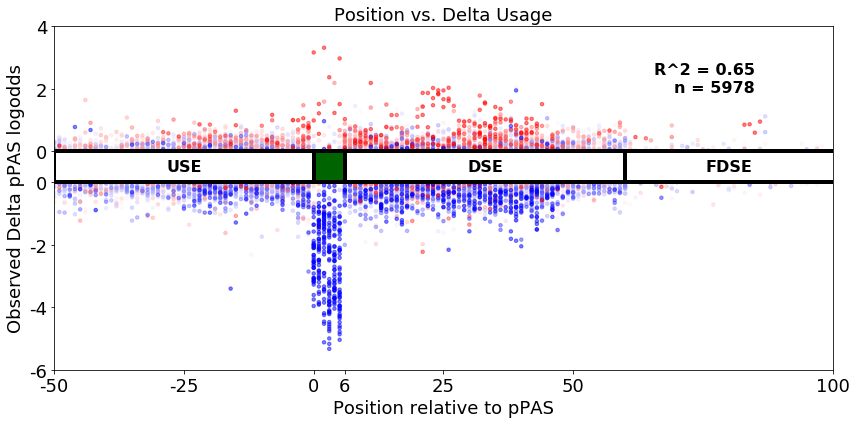

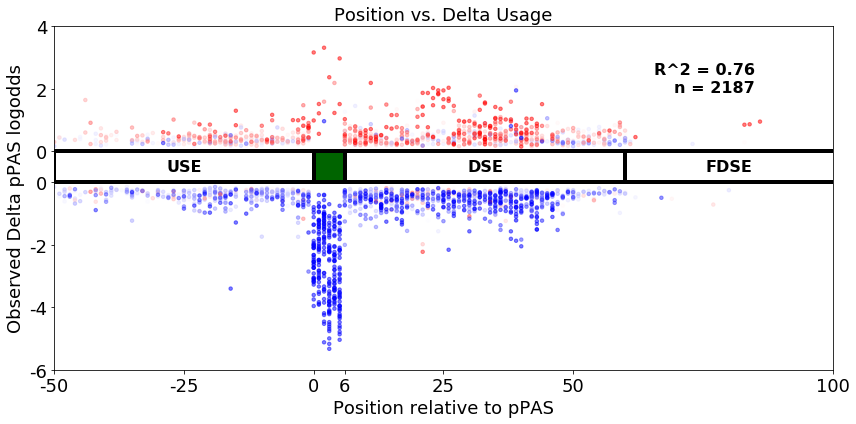

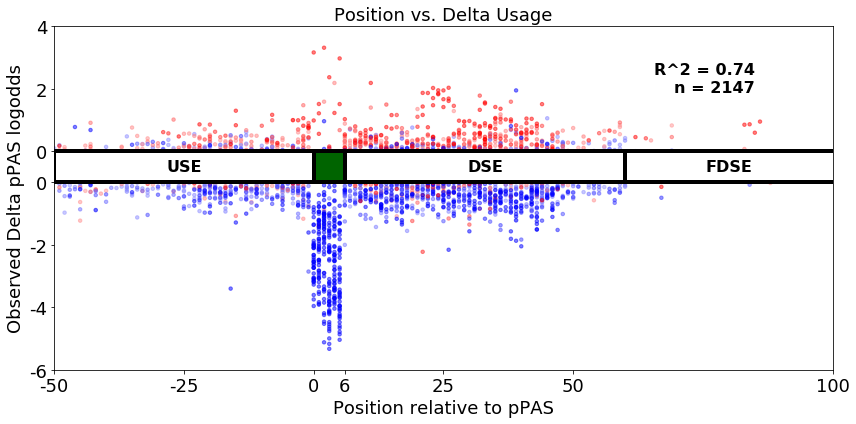

In [49]:
#Held out gene variant prediction tests
save_figs = False

#All variants
df_to_use = variant_df_filtered.loc[variant_df_filtered.gene.isin(held_out_genes)]

figsize=(12, 6)

fig_name = None
if save_figs :
    fig_name = 'position_delta_all'
plot_position_delta_scatter(df_to_use, min_pred_filter=0.0, pred_column='weighted_delta_logodds_pred', figsize=figsize, fig_name=fig_name, vmin=-0.5, vmax=0.5, fig_dpi=150, annotate=None)

#Significant variants
df_to_use = variant_df_filtered.loc[variant_df_filtered.gene.isin(held_out_genes)].query("delta_p_val < 0.0001")

figsize=(12, 6)

fig_name = None
if save_figs :
    fig_name = 'position_delta_all'
plot_position_delta_scatter(df_to_use, min_pred_filter=0.0, pred_column='weighted_delta_logodds_pred', figsize=figsize, fig_name=fig_name, vmin=-0.5, vmax=0.5, fig_dpi=150, annotate=None)


#Filtered on prediction >= (log)
df_to_use = variant_df_filtered.loc[variant_df_filtered.gene.isin(held_out_genes)]

fig_name = None
if save_figs :
    fig_name = 'position_delta_all_pred_ge_02'
plot_position_delta_scatter(df_to_use, min_pred_filter=0.2, pred_column='weighted_delta_logodds_pred', figsize=figsize, fig_name=fig_name, vmin=-0.5, vmax=0.5, fig_dpi=150, annotate=None)
